In [1]:
import cv2
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
#from torch.autograd import Variable
from tqdm import tqdm
#from libs.service_defs import *
#import torch.autograd as autograd
#from scipy import stats
from torch.utils.tensorboard import SummaryWriter

from typing import Tuple, List, Type, Dict, Any

In [43]:
class DS(Dataset):
    def __init__(self, img_dict: str = '', mask=False):
        
        self.dict = np.loadtxt(fname=img_dict, usecols=0, dtype=str)
        self.transforms = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()
                        ])
        self.mask = mask
        self.img_shape = (256, 256)
    
    def get_mask(self) :
        
        mask_id = np.random.randint(low=0, high=4000)
        mask_fname = './mask/mask_dataset/' + str(mask_id).zfill(5) + '.png'
        mask = cv2.imread(mask_fname, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, self.img_shape, interpolation=cv2.INTER_LINEAR)
        mask = mask / 255.0
        return mask

    def __getitem__(self, index):
        
        img_src = self.dict[index]
        img = cv2.imread(img_src)
        img = img / 255.0
        struct_src = img_src[:3] + '_structure' + img_src[3:]
        structure = cv2.imread(struct_src)
        structure = structure / 255.0
        mask = np.zeros_like(img)
        if self.mask :
            mask = self.get_mask()
            mask = np.resize(mask, (256, 256, 1))
            mask = np.repeat(mask, 3, axis=2)
            img = img * (np.ones_like(mask) - mask) + mask * np.ones_like(mask)
            structure = structure * (np.ones_like(mask) - mask) + mask * np.ones_like(mask)
        img = self.transforms(img)
        #img = img.unsqueeze(0)
        structure = self.transforms(structure)
        #structure = structure.unsqueeze(0)
        return img, mask, structure

    def __len__(self):
        return len(self.dict)

In [47]:
dataset = DS(img_dict='dict.txt', mask=True)

In [36]:
dataset[0][2].shape

torch.Size([3, 256, 256])

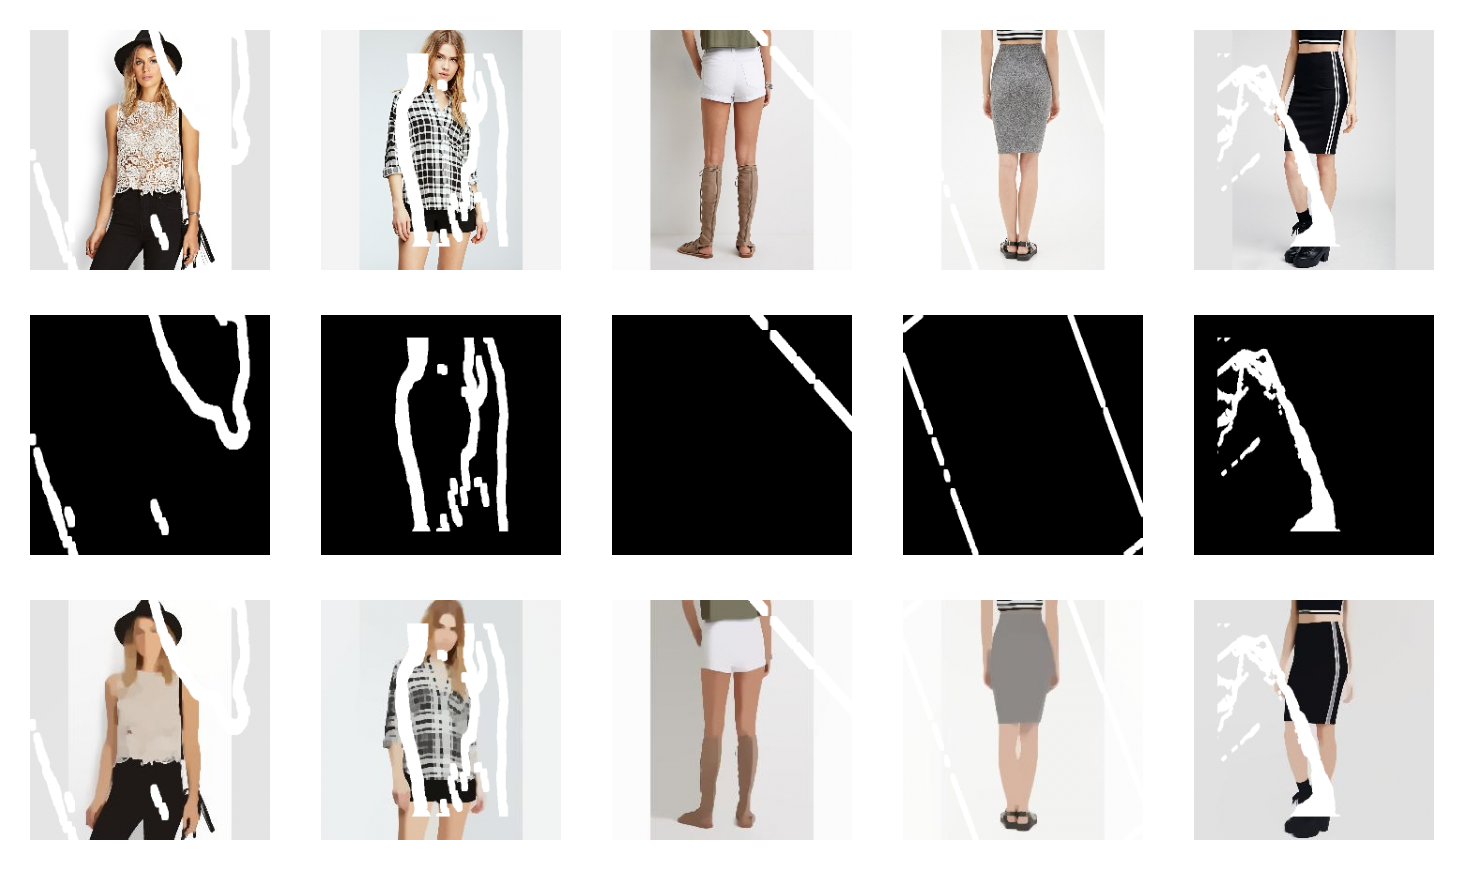

In [34]:
indices = np.random.randint(0, len(dataset), size=5)
samples = [dataset[idx] for idx in indices]
fig = plt.figure(figsize=(5, 3), dpi=300)
for idx,sample in enumerate(samples):
    img = sample[0].squeeze(0).permute(1,2,0).numpy()
    p = plt.subplot(3,5,idx+1)
    plt.imshow(img[...,::-1])
    plt.axis('off')
    
    mask = sample[1]
    p = plt.subplot(3,5,5+idx+1)
    plt.imshow(mask)
    plt.axis('off')
    
    structure = sample[2].squeeze(0).permute(1,2,0).numpy()
    p = plt.subplot(3,5,10+idx+1)
    plt.imshow(structure[...,::-1])
    plt.axis('off')
    
plt.tight_layout()
fig.patch.set_facecolor('white')

In [48]:
train_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=32)

In [49]:
for batch in train_loader : 
    break
batch[0].shape

torch.Size([32, 3, 256, 256])

In [ ]:
class StructureGen(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_res=4, activ='relu', 
                 norm='in', pad_type='reflect', use_sn=True):
        super(StructureGen, self).__init__()

        self.down_sample=nn.ModuleList()
        self.up_sample=nn.ModuleList()
        self.content_param=nn.ModuleList()

        self.input_layer = Conv2dBlock(input_dim*2+1, dim, 7, 1, 3, norm, activ, pad_type, use_sn=use_sn)
        self.down_sample += [nn.Sequential(
            Conv2dBlock(dim, 2*dim, 4, 2, 1, norm, activ, pad_type, use_sn=use_sn),
            Conv2dBlock(2*dim, 2*dim, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn))]

        self.down_sample += [nn.Sequential(
            Conv2dBlock(2*dim, 4*dim, 4, 2, 1,norm, activ, pad_type, use_sn=use_sn),
            Conv2dBlock(4*dim, 4*dim, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn))]

        self.down_sample += [nn.Sequential(
            Conv2dBlock(4*dim, 8*dim, 4, 2, 1,norm, activ, pad_type, use_sn=use_sn))]
        dim = 8*dim
        # content decoder
        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim, dim // 2, 5, 1, 2, norm, activ, pad_type, use_sn=use_sn)) )]

        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim//2, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim//2, dim//4, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn)) )]

        self.up_sample += [(nn.Sequential(
            ResBlocks(n_res, dim//4, norm, activ, pad_type=pad_type),
            nn.Upsample(scale_factor=2),
            Conv2dBlock(dim//4, dim//8, 5, 1, 2,norm, activ, pad_type, use_sn=use_sn)) )]  

        self.content_param += [Conv2dBlock(dim//2, dim//2, 5, 1, 2, norm, activ, pad_type)]
        self.content_param += [Conv2dBlock(dim//4, dim//4, 5, 1, 2, norm, activ, pad_type)]
        self.content_param += [Conv2dBlock(dim//8, dim//8, 5, 1, 2, norm, activ, pad_type)]                                     

        self.image_net = Get_image(dim//8, input_dim)

    def forward(self, inputs):
        x0 = self.input_layer(inputs)
        x1 = self.down_sample[0](x0)
        x2 = self.down_sample[1](x1)
        x3 = self.down_sample[2](x2)

        u1 = self.up_sample[0](x3) + self.content_param[0](x2)
        u2 = self.up_sample[1](u1) + self.content_param[1](x1)
        u3 = self.up_sample[2](u2) + self.content_param[2](x0)        

        images_out = self.image_net(u3)   
        return images_out  


class Conv2dBlock(nn.Module):
    def __init__(self, input_dim ,output_dim, kernel_size, stride,
                 padding=0, norm='none', activation='relu', pad_type='zero', dilation=1, 
                 use_bias=True, use_sn=False):
        super(Conv2dBlock, self).__init__()
        self.use_bias = use_bias
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        if use_sn:
            self.conv = spectral_norm(nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias, dilation=dilation))
        else:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias, dilation=dilation)

    def forward(self, x):
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)           
        if self.activation:
            x = self.activation(x)
        return x


class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, pad_type=pad_type, use_sn=use_sn)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(ResBlock, self).__init__()

        model = []
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type, use_sn=use_sn)]
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation='none', pad_type=pad_type, use_sn=use_sn)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        residual = x
        out = self.model(x)
        out += residual
        return out  


class Discriminator(nn.Module):
    def __init__(self, input_dim=3, dim=64, n_layers=3, 
                norm='none', activ='lrelu', pad_type='reflect', use_sn=True):
        super(Discriminator, self).__init__()
        
        self.model = nn.ModuleList()
        self.model.append(Conv2dBlock(input_dim,dim,4,2,1,'none',activ,pad_type,use_sn=use_sn))
        dim_in = dim
        for i in range(n_layers - 1):
            dim_out = min(dim*8, dim_in*2)
            self.model.append(DownsampleResBlock(dim_in,dim_out,'none',activ,pad_type,use_sn))
            dim_in = dim_out

        self.model.append(Conv2dBlock(dim_in,1,1,1,activation='none',use_bias=False, use_sn=use_sn))
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class DownsampleResBlock(nn.Module):
    def __init__(self, input_dim, output_dim, norm='in', activation='relu', pad_type='zero', use_sn=False):
        super(DownsampleResBlock, self).__init__()
        self.conv_1 = nn.ModuleList()
        self.conv_2 = nn.ModuleList()

        self.conv_1.append(Conv2dBlock(input_dim,input_dim,3,1,1,'none',activation,pad_type,use_sn=use_sn))
        self.conv_1.append(Conv2dBlock(input_dim,output_dim,3,1,1,'none',activation,pad_type,use_sn=use_sn))
        self.conv_1.append(nn.AvgPool2d(kernel_size=2, stride=2))
        self.conv_1 = nn.Sequential(*self.conv_1)


        self.conv_2.append(nn.AvgPool2d(kernel_size=2, stride=2))
        self.conv_2.append(Conv2dBlock(input_dim,output_dim,1,1,0,'none',activation,pad_type,use_sn=use_sn))
        self.conv_2 = nn.Sequential(*self.conv_2)


    def forward(self, x):
        out = self.conv_1(x) + self.conv_2(x)
        return out

class MultiDiscriminator(nn.Module):
    def __init__(self, **parameter_dic):
        super(MultiDiscriminator, self).__init__()
        self.model_1 = Discriminator(**parameter_dic)
        self.down = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
        self.model_2 = Discriminator(**parameter_dic)
        
    def forward(self, x):
        pre1 = self.model_1(x)
        pre2 = self.model_2(self.down(x))
        return [pre1, pre2]        


In [ ]:
structure_param = {'input_dim':3, 'dim':64, 'n_res':4, 'activ':'relu', 
                        'norm':'in', 'pad_type':'reflect', 'use_sn':True}
dis_param =  {'input_dim':3, 'dim':64, 'n_layers':3, 'norm':'none',
                   'activ':'lrelu', 'pad_type':'reflect', 'use_sn':True}
s_gen = StructureGen(**structure_param)
s_dis = MultiDiscriminator(**dis_param)  

l1_loss = nn.L1Loss()
adversarial_loss = AdversarialLoss(type=config.DIS_GAN_LOSS)
correctness_loss = PerceptualCorrectness()
vgg_style = StyleLoss()
vgg_content = PerceptualLoss()